In [4]:
import os
import numpy as np
import torch
from PIL import Image
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns

In [52]:
import cv2
class CubicasaDataset(object):
    def __init__(self, root, mode, transforms=None):
        self.root = root
        self.dict = torch.load(f"data/cubicasa5k/instance_info_{mode}.pt")
        self.transforms = transforms
        self.imgs = np.genfromtxt(root + '/'+mode+'.txt', dtype='str')
    
        
    def __getitem__(self, idx):
        # load images ad masks
        
        instance_info = self.dict[self.imgs[idx]]
        
#         fplan = cv2.imread()
#         img = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
        img = Image.open(self.root + self.imgs[idx]+'F1_original.png').convert("RGB")
        #img = np.moveaxis(fplan, -1, 0)

        target = {}
        target["boxes"] = instance_info['boxes']
        target["labels"] = instance_info['labels'].long()
        target["masks"] = torch.as_tensor(instance_info['masks'], dtype=torch.uint8)
        target["image_id"] = torch.tensor([idx], dtype = torch.int8)
        target["area"] = instance_info['area']
        target["iscrowd"] = instance_info['iscrowd']

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
    

In [67]:
from floortrans.loaders.house import House
import copy

room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
rooms = ["Outdoor", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
room_ids = [1,3,4,5,6,7,8,9,10,11]
room_labels = {rooms[i]:i+1 for i in range(len(rooms))}


class CubicasaDataset(object):
    def __init__(self, root, mode, transforms=None):
        self.root = root
        #self.dict = torch.load(f"data/cubicasa5k/instance_info_{mode}.pt")
        self.transforms = transforms
        self.imgs = np.genfromtxt(root + '/'+mode+'.txt', dtype='str')
    
        
    def __getitem__(self, idx):
        # load images ad masks
        
        #instance_info = self.dict[self.imgs[idx]]
        
        # fplan = cv2.imread(self.root + self.imgs[idx]+'F1_original.png')
        # img = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)/255.  # correct color channels

        org_img_path = self.root + self.imgs[idx]+'F1_original.png'
        img_path = self.root + self.imgs[idx]+'F1_scaled.png'
        svg_path = self.root + self.imgs[idx]+'model.svg'

        img = Image.open(org_img_path).convert("RGB")

        height, width, _ = cv2.imread(img_path).shape
        #height_org, width_org, _ = cv2.imread(org_img_path).shape

        # Getting labels for segmentation and heatmaps
        house = House(svg_path, height, width)
        # Combining them to one numpy tensor
        label = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

        label = label.unsqueeze(0)
        label = torch.nn.functional.interpolate(label,
                                                    size=(height, width),
                                                    mode='nearest')
        label = label.squeeze(0)[0]


        #############process items##############
        masks = label.data.numpy()
    
        boxes = []
        labels = []
        num_obj = 0
        
        mask_tensor = []
        areas = []
        
        for r in room_ids:
            x = copy.copy(masks)
            x[masks != r] = 0 
            x = x.astype(np.uint8)
            contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            
            for tcnt in contours: 
                
                im = np.zeros((height,width,3), np.uint8)
                im = cv2.drawContours(im, [tcnt], -1, (255,255,255), -1)
                mask_tensor.append((im[:,:,0]/255).astype(np.int8))
                areas.append(cv2.contourArea(tcnt,False) )
                x,y,w,h = cv2.boundingRect(tcnt)
                boxes.append([x,y,x+w,y+h])
                labels.append(room_labels[room_classes[r]])
                num_obj+=1
        
        try:
            mask_tensor = np.stack(mask_tensor, 0)
        except:
            mask_tensor = np.array([])


        #######################################

        #img = np.moveaxis(fplan, -1, 0)

        target = {}
        target["boxes"] = torch.as_tensor(boxes)
        target["labels"] = torch.as_tensor(labels, dtype = torch.long)
        target["masks"] = torch.as_tensor(mask_tensor, dtype=torch.uint8)
        target["image_id"] = torch.tensor([idx], dtype = torch.int8)
        target["area"] = torch.as_tensor(areas)
        target["iscrowd"] = torch.zeros(num_obj, dtype = torch.int8)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [88]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 10+1  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [89]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=9,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


In [90]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [91]:
import transforms as T
import utils
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [92]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = CubicasaDataset('data/cubicasa5k', 'test',get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True,collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [93]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 1+10
    # use our dataset and defined transformations
    dataset = CubicasaDataset('data/cubicasa5k', 'val',get_transform(train=True))

    dataset_test = CubicasaDataset('data/cubicasa5k', 'test',get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, 
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, 
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [97]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1+10
# use our dataset and defined transformations
dataset = CubicasaDataset('data/cubicasa5k', 'val',get_transform(train=True))

dataset_test = CubicasaDataset('data/cubicasa5k', 'test',get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, 
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, 
        collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

    

In [98]:
device == torch.device('cpu')

True

In [99]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

KeyError: 'memory'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


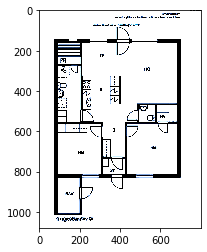

In [87]:
plt.imshow(np.moveaxis(images[0].numpy().data,0,-1))